In [20]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import csv

In [21]:
# constants

G = 6.67e-8 # Newton's constant in cgs
c = 2.998e10 # speed of light in cgs
kpc = 3.086e21 # kiloparsec in cm

In [22]:
# define continuous gravitational waveform template

frot_inj = 182.

def hplus(t,h0plus,f0,f0dot):
    
    return h0plus*np.cos(np.pi*f0dot*t**2 + 2.*np.pi*f0*t)

def hcross(t,h0cross,f0,f0dot,alpha):
    
    return h0cross*np.cos(np.pi*f0dot*t**2 + 2.*np.pi*f0*t + alpha)

def Fplus(theta,phi): # from Maggiore p. 342
    
    return 0.5*(1.+np.cos(theta)**2)*np.cos(2.*phi)

def Fcross(theta,phi): # from Maggiore p. 342
    
    return np.cos(theta)*np.sin(2.*phi)

def theta(t,theta0):
    
    return theta0 #+2*np.pi*t/(24.*60.*60)

def phi(t,phi0):
    
    return phi0 #+2.*np.pi*t/(24.*60.*60.)

def h(t,h0plus,h0cross,f0,f0dot,alpha,theta0,phi0):
    
    return Fplus(theta(t,theta0),phi(t,phi0))*hplus(t,h0plus,f0,f0dot) + Fcross(theta(t,theta0),phi(t,phi0))*hcross(t,h0cross,f0,f0dot,alpha)

def ht(t,fdot,e,dL=10.*kpc,i=0.,frot=frot_inj,theta0=np.pi/4.,phi0=0.):

    f0 = 2.*frot
    I = 1e45

    h0 = 4.*np.pi**2*G*I*f0**2*e/(c**4*dL)
    h0plus = h0*(1.+np.cos(i)**2)/2.
    h0cross = h0*np.cos(i)*(1.+np.cos(i)**2)/2.
    alpha = np.pi/2.

    return h(t,h0plus,h0cross,f0,fdot,alpha,theta0,phi0)


In [23]:
class Template:
    def __init__(self, theta=np.pi/4, phi=0, iota=0, f_rot0=0, df_dt=-1, I_3=(2/5) * (1.4 * 2 * 1e30) * (1.2 * 1e4)**2, epsilon=0, r=3.086e+20):  #spoofed 10 times closer
        self.theta = theta
        self.phi = phi
        self.iota = iota
        self.f_rot0 = f_rot0
        self.df_dt = df_dt
        self.I_3 = I_3
        self.epsilon = epsilon
        self.r = r

        self.G = 6.67 * 1e-11 # m^3 kg^-1 s^-2
        self.c = 3e8 # m s^-1

    def __call__(self, t):
        self.f_gw = self.df_dt * t + 2*self.f_rot0
        self.h_0 = 4 * np.pi ** 2 * self.G / self.c ** 4 * self.I_3 * (2 * self.f_rot0) ** 2 / self.r * self.epsilon

        print('for (epsilon, fdot) = (%f, %f), h_0 * 1e30 = %f' %(self.epsilon, self.df_dt, self.h_0 * 1e30))

        h_plus = (1/2) * (1 + np.cos(self.theta)**2) * np.cos(2*self.phi) * self.h_0 * (1 + np.cos(self.iota)**2) / 2 * np.cos(2 * np.pi * self.f_gw * t)
        h_cross = np.cos(self.theta) * np.sin(2 * self.phi) * self.h_0 * np.cos(self.iota) * np.sin(2 * np.pi * self.f_gw * t)

        h = h_plus + h_cross

        return h

In [24]:
filepath = 'simple-cw-master/'
filename = 'cw_' + 'example' + '.csv'

ts = []
hs = []

with open(filepath + filename) as file:
    raw_read = csv.reader(file)
    next(raw_read)
    for row in raw_read:
        # f_rot.append(float(row[0]))
        ts.append(float(row[0]))
        hs.append(float(row[1]))
        
ts = np.array(ts)
hs = np.array(hs)

fdot_inj = 2e-4
e_inj = 5e-6

fmin, fmax = (1e-4,10e-4)
emin, emax = (1e-6,10e-6)

In [25]:
template = Template(epsilon=e_inj, df_dt=fdot_inj, f_rot0=frot_inj)
model = template(ts)

for (epsilon, fdot) = (0.000005, 0.000200), h_0 * 1e30 = 112553.218009


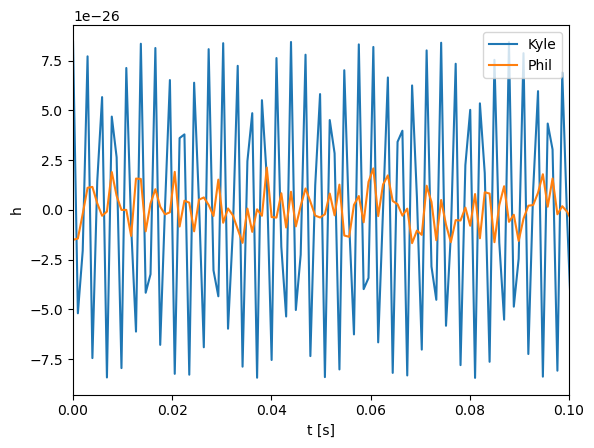

In [33]:
plt.plot(ts, model, label='Kyle')
plt.plot(ts,hs-ht(ts,fdot_inj,e_inj),label='Phil')


# plt.xlim(0.,4./200.)
plt.xlim(0, 0.1)
plt.xlabel('t [s]')
plt.ylabel('h')
plt.legend()

plt.show()